In [1]:
import os
import pickle
from itertools import combinations
import math
import pandas as pd
import re
import json
import binarymap as bmap
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine
import jax
import jax.numpy as jnp
from jax.experimental import sparse
from jaxopt import ProximalGradient
import jaxopt
import numpy as onp
from scipy.stats import pearsonr
from tqdm.notebook import tqdm

import sys
sys.path.append("..")

# from multidms.utils import *
# from multidms.plot import *

from timeit import default_timer as timer
# from multidms.model import ϕ, g, prox, cost_smooth

In [2]:
import importlib

In [3]:
import sys
sys.path.append("..")
import multidms

### Globals

In [4]:
# exp_name = "clip_search"
substitution_column = 'aa_substitutions_reference'
experiment_column = 'homolog_exp'
scaled_func_score_column = 'log2e'

In [5]:
func_score_data = pd.DataFrame()
sites = {}
wt_seqs = {}

for homolog in ["Delta", "Omicron_BA.1"]:
    
    # functional scores
    func_sel = pd.read_csv(f"../results/{homolog}/functional_selections.csv")
    func_sel = func_sel.assign(
        filename = f"../results/{homolog}/" + 
        func_sel.library + "_" + 
        func_sel.preselection_sample + 
        "_vs_" + func_sel.postselection_sample + 
        "_func_scores.csv"
    )
    func_sel = func_sel.assign(
        func_sel_scores_df = func_sel.filename.apply(lambda f: pd.read_csv(f))
    )
    func_sel = func_sel.assign(
        len_func_sel_scores_df = func_sel.func_sel_scores_df.apply(lambda x: len(x))
    )
    fun_sel = func_sel.assign(homolog = homolog)
    func_score_data = pd.concat([func_score_data, fun_sel]).reset_index(drop=True)
    
    # WT Protein sequence
    with open(f"../results/{homolog}/protein.fasta", "r") as seq_file:
        header = seq_file.readline()
        wt_seqs[homolog] = seq_file.readline().strip()

    # Sites
    sites[homolog] = (
        pd.read_csv(f"../results/{homolog}/site_numbering_map.csv")
        .rename({"sequential_site":f"{homolog}_site", "sequential_wt":f"{homolog}_wt"})
        .set_index(["reference_site"])
    )

# Add a column that gives a unique ID to each homolog/DMS experiment
func_score_data['homolog_exp'] = func_score_data.apply(
    lambda row: f"{row['homolog']}-{row['library']}-{row['replicate']}".replace('-Lib',''),
    axis=1
)

In [6]:
fit_params = {
    "fs_scaling_group_column" : "homolog_exp",
    "min_pre_counts" : 100,
    "pseudocount" : 0.1,
    "agg_variants" : True,
    "sample" : None, #3000,
    "min_pre_counts" : 100,
    "clip_target" : None,
    "func_score_target" : 'log2e',
    "experiment_ref" :'Delta-3-1',
    "experiment_2" : 'Omicron_BA.1-3-1',
    "shift_func_score_target_nonref" : None, #-1,
    "warmup_to_ref" : False,
    "maxiter" : 10000,
    "λ_lasso" : 1e-5,
    "λ_ridge" : 0
}

In [7]:
# ! rm results.pkl

In [8]:
# if not os.path.exists(f"{exp_name}.pkl"):
#     cols = list(fit_params.keys()) + [
#         "tuned_model_params", "all_subs", "variant_prediction_df"
#     ]
#     results = pd.DataFrame(columns = cols)
# else:
#     results = pickle.load(open(f"{exp_name}.pkl", "rb"))

In [9]:
if fit_params["experiment_2"]:
    func_score_data = func_score_data.query(
        f"{experiment_column}.isin(['{fit_params['experiment_ref']}', '{fit_params['experiment_2']}'])"
    )

In [10]:
func_score_df = pd.DataFrame()
for idx, row in tqdm(func_score_data.iterrows(), total=len(func_score_data)):
    df = row.func_sel_scores_df.assign(homolog=row.homolog)
    df = df.assign(library = row.library)
    df = df.assign(replicate = row.replicate)
    exp_func_score_df = df.assign(homolog_exp=row.homolog_exp)
    func_score_df = pd.concat([func_score_df, exp_func_score_df])

  0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
if fit_params["sample"]:
    func_score_df = func_score_df.sample(fit_params["sample"])

In [12]:
func_score_df.aa_substitutions_reference.fillna("", inplace=True)
gapped_sub_vars = []
stop_wt_vars = []
non_numeric_sites = []
for idx, row in tqdm(func_score_df.iterrows(), total=len(func_score_df)):
    if "-" in row[substitution_column]:
        gapped_sub_vars.append(idx)
    for sub in row[substitution_column].split():
        if sub[0] == "*":
            stop_wt_vars.append(idx)
        if not sub[-2].isnumeric():
            non_numeric_sites.append(idx)

to_drop = set.union(set(gapped_sub_vars), set(stop_wt_vars), set(non_numeric_sites))
func_score_df.drop(to_drop, inplace=True)

  0%|          | 0/162830 [00:00<?, ?it/s]

In [13]:
# TODO re-write and make function
# def normalize_by_freq()?
dfs = []
for (h, hdf) in func_score_df.groupby(fit_params["fs_scaling_group_column"]):
    n_post_counts = sum(hdf['post_count'])
    if 'Delta' in h:
        bottleneck = 1e5
        scaling_factor = bottleneck / n_post_counts # scaling_factor = 0.05
    else:
        bottleneck = 1e5
        scaling_factor = bottleneck / n_post_counts # scaling_factor = 0.05
    hdf['orig_post_count'] = hdf['post_count']
    hdf['post_count'] *= scaling_factor
    hdf['post_count_wt'] *= scaling_factor
    print(h, n_post_counts, round(scaling_factor, 2), round(sum(hdf['post_count']),2))

    # Recompute enrichment ratios with new counts
    hdf['pre_count_ps'] = hdf['pre_count'] + fit_params["pseudocount"]
    hdf['post_count_ps'] = hdf['post_count'] + fit_params["pseudocount"]
    hdf['pre_count_wt_ps'] = hdf['pre_count_wt'] + fit_params["pseudocount"]
    hdf['post_count_wt_ps'] = hdf['post_count_wt'] + fit_params["pseudocount"]

    total_pre_count = sum(hdf['pre_count_ps'])
    total_post_count = sum(hdf['post_count_ps'])

    hdf['pre_freq'] = hdf['pre_count_ps'] / total_pre_count
    hdf['post_freq'] = hdf['post_count_ps'] / total_post_count
    hdf['pre_freq_wt'] = hdf['pre_count_wt_ps'] / total_pre_count
    hdf['post_freq_wt'] = hdf['post_count_wt_ps'] / total_post_count

    hdf['wt_e'] = hdf['post_freq_wt'] / hdf['pre_freq_wt']
    hdf['var_e'] = hdf['post_freq'] / hdf['pre_freq']
    hdf['e'] = hdf['var_e'] / hdf['wt_e']
    #hdf.dropna(subset=['e'], inplace=True)
    hdf['log2e'] = hdf['e'].apply(lambda x: math.log(x, 2))
    dfs.append(hdf)
func_score_df = pd.concat(dfs)

Delta-3-1 3807421 0.03 100000.0
Omicron_BA.1-3-1 66389368 0.0 100000.0


In [14]:
# Drop barcoded variants with pre-counts below a threshold
n_pre_threshold = len(func_score_df)
func_score_df = func_score_df[func_score_df['pre_count'] >= fit_params["min_pre_counts"]]
#     print(f'Of {n_pre_threshold} variants, {n_pre_threshold - len(func_score_df)} had fewer than {min_pre_counts} counts before selection, and were filtered out')

In [15]:
if fit_params["agg_variants"]:
    func_score_df = func_score_df.groupby([substitution_column, experiment_column]).mean().reset_index()
func_score_df["pre_count"] = func_score_df["pre_count"].astype(int)
func_score_df["post_count"] = func_score_df["post_count"].astype(int)

In [16]:
# TODO, what's the order of operations?
if fit_params["shift_func_score_target_nonref"]:
    h2_idx = func_score_df.query(f"{experiment_column} == '{fit_params['experiment_2']}'").index
    func_score_df.loc[h2_idx, fit_params["func_score_target"]] += fit_params["shift_func_score_target_nonref"]

In [17]:
if fit_params['clip_target']:
    tar = fit_params["func_score_target"]
    func_score_df[tar] = func_score_df[tar].clip(*fit_params["clip_target"])

In [18]:
importlib.reload(multidms.utils)
importlib.reload(multidms.model)
importlib.reload(multidms.plot)

<module 'multidms.plot' from '/home/jgallowa/Projects/multidms/notebooks/../multidms/plot.py'>

In [19]:
cols = list(fit_params.keys()) + [
    "tuned_model_params", "all_subs", "variant_prediction_df"
]
results = pd.DataFrame(columns = cols)

In [20]:
# multidms = importlib.reload(multidms)
(X, y), df, all_subs, site_map = multidms.utils.create_homolog_modeling_data(
                            func_score_df, 
                            experiment_column,
                            fit_params["experiment_ref"],
                            substitution_column,
                            fit_params["func_score_target"]
                        )

sig_upper = df[fit_params["func_score_target"]].quantile(0.95)
sig_lower = df[fit_params["func_score_target"]].quantile(0.05)
sig_range = sig_upper - sig_lower

Found 8 site(s) lacking data in at least one homolog.
2723 of the 86572 variants were removed because they had mutations at the above sites, leaving 83849 variants.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58556/58556 [01:55<00:00, 506.22it/s]


There were 0 cache hits in total for homolog Omicron_BA.1-3-1.


In [21]:
# Initialize all params
params = multidms.utils.initialize_model_params(
    func_score_df[experiment_column].unique(), 
    n_beta_shift_params=X[fit_params["experiment_ref"]].shape[1],
#     include_alpha=True,
    init_sig_range=sig_range,
    init_sig_min=sig_lower
)

In [22]:
params

{'β': DeviceArray([-0.57334713, -0.20234694, -0.40719932, ..., -0.68163857,
               0.71620482,  0.99943656], dtype=float64),
 'S_Delta-3-1': DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float64),
 'C_Delta-3-1': DeviceArray([0.], dtype=float64),
 'γ_Delta-3-1': DeviceArray([0.], dtype=float64),
 'S_Omicron_BA.1-3-1': DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float64),
 'C_Omicron_BA.1-3-1': DeviceArray([0.], dtype=float64),
 'γ_Omicron_BA.1-3-1': DeviceArray([0.], dtype=float64),
 'α': {'ge_scale': DeviceArray([4.20404354], dtype=float64),
  'ge_bias': DeviceArray([-3.36967609], dtype=float64)},
 'C_ref': DeviceArray([5.], dtype=float64)}

In [23]:
print(f"\nPre-Optimization")
print(f"----------------")
print(f"cost = {multidms.model.cost_smooth(params, (X, y), λ_ridge=fit_params['λ_ridge']):.2e}")

tol = 1e-6
maxiter = fit_params['maxiter']
start = timer()

solver = ProximalGradient(multidms.model.cost_smooth, multidms.model.prox, tol=tol, maxiter=maxiter)

# First, just fit data on reference homolog
if fit_params["warmup_to_ref"]:
    print('Fitting model to just the reference homolog')
    params, state = solver.run(
        params, 
        hyperparams_prox = dict(
            lasso_params = None,
            lock_params = {
                f"S_{fit_params['experiment_ref']}" : jnp.zeros(len(params['β'])),
                f"S_{fit_params['experiment_2']}" : jnp.zeros(len(params['β'])),
                f"C_{fit_params['experiment_ref']}" : jnp.zeros(shape=(1,)),
                f"C_{fit_params['experiment_2']}" : jnp.zeros(shape=(1,))
            }
        ),
        data=(
            {fit_params['experiment_ref'] : X[fit_params['experiment_ref']]},
            {fit_params['experiment_ref'] : y[fit_params['experiment_ref']]}
        ),
        λ_ridge=0
    )

# Next, jointly fit data on both homologs
print('Fitting model to both homologs')
params, state = solver.run(
    params, 
    hyperparams_prox = dict(
        lasso_params = {
            f"S_{fit_params['experiment_2']}" : fit_params['λ_lasso']
        },
        lock_params = {
            f"S_{fit_params['experiment_ref']}" : jnp.zeros(len(params['β'])),
            f"C_{fit_params['experiment_ref']}" : jnp.zeros(shape=(1,)),
            f"C_{fit_params['experiment_2']}" : jnp.zeros(shape=(1,))
        }
    ),
    data=(X, y),
    λ_ridge=fit_params['λ_ridge']
)
end = timer()

print(f"\nPost-Optimization")
print(f"-----------------")
print(f"Full model optimization: {state.iter_num} iterations")
print(f"error = {state.error:.2e}")
print(f"cost = {multidms.model.cost_smooth(params, (X, y)):.2e}")
print(f"Wall time for fit: {end - start}")

for param in ["β", f"S_{fit_params['experiment_2']}"]:
    print(f"\nFit {param} distribution\n===============")
    if param not in params:
        continue
    arr = onp.array(params[param])
    mean = onp.mean(arr)
    median = onp.median(arr)

    # measures of dispersion
    min = onp.amin(arr)
    max = onp.amax(arr)
    range = onp.ptp(arr)
    variance = onp.var(arr)
    sd = onp.std(arr)

    print("Descriptive analysis")
    print("Measures of Central Tendency")
    print(f"Mean = {mean:.2e}")
    print(f"Median = {median:.2e}")
    print("Measures of Dispersion")
    print(f"Minimum = {min:.2e}")
    print(f"Maximum = {max:.2e}")
    print(f"Range = {range:.2e}")
    print(f"Variance = {variance:.2e}")
    print(f"Standard Deviation = {sd:.2e}")

for param, value in params.items():
    if param in ["β", f"S_{fit_params['experiment_2']}"]: continue
    print(f"{param}: {value}")

df["predicted_latent_phenotype"] = onp.nan
df[f"predicted_{fit_params['func_score_target']}"] = onp.nan

print(f"\nRunning Predictions")
print(f"-------------------")
for homolog, hdf in df.groupby(experiment_column):
    
    h_params = {
        "α":params["α"],
        "β":params["β"], 
        "C_ref":params["C_ref"],
        "S":params[f"S_{homolog}"], 
        "C":params[f"C_{homolog}"],
        "γ":params[f"γ_{homolog}"]
    }
    z_h = multidms.model.ϕ(h_params, X[homolog])
    df.loc[hdf.index, "predicted_latent_phenotype"] = z_h
    
    y_h_pred = multidms.model.f(h_params, X[homolog])
    df.loc[hdf.index, f"predicted_{fit_params['func_score_target']}"] = y_h_pred
print(f"\nDONE :)")
print(f"-------------------")

row = fit_params.copy()
row["tuned_model_params"] = params.copy()
row["all_subs"] = all_subs.copy()
row["variant_prediction_df"] = df.drop("index", axis=1)

# results = pd.Series(row)
results.loc[len(results)] = pd.Series(row)


Pre-Optimization
----------------
cost = 2.94e+00
Fitting model to both homologs

Post-Optimization
-----------------
Full model optimization: 10000 iterations
error = 8.64e-04
cost = 5.54e-01
Wall time for fit: 109.75080712977797

Fit β distribution
Descriptive analysis
Measures of Central Tendency
Mean = -1.32e+00
Median = -7.85e-01
Measures of Dispersion
Minimum = -1.23e+01
Maximum = 9.62e+00
Range = 2.19e+01
Variance = 5.13e+00
Standard Deviation = 2.26e+00

Fit S_Omicron_BA.1-3-1 distribution
Descriptive analysis
Measures of Central Tendency
Mean = -4.89e-02
Median = 0.00e+00
Measures of Dispersion
Minimum = -6.54e+00
Maximum = 5.39e+00
Range = 1.19e+01
Variance = 5.67e-01
Standard Deviation = 7.53e-01
C_Delta-3-1: [0.]
C_Omicron_BA.1-3-1: [0.]
C_ref: [2.84029376]
S_Delta-3-1: [0. 0. 0. ... 0. 0. 0.]
α: {'ge_bias': DeviceArray([-3.10433876], dtype=float64), 'ge_scale': DeviceArray([3.92671409], dtype=float64)}
γ_Delta-3-1: [-0.66125379]
γ_Omicron_BA.1-3-1: [0.92659113]

Running P

In [24]:
# start = timer()

# for clip in [None, [-4, 4]]:
#     i_fit_params = fit_params.copy()
#     i_fit_params["clip_target"] = clip
#     row = run_fit(func_score_data.copy(), fit_params = i_fit_params)
#     results.loc[len(results)] = row

# pickle.dump(results, open(f"{exp_name}.pkl", "wb"))

# end = timer()
# print(f"This experiment took {(end - start) / 60} mins.")

fs_scaling_group_column                                                 homolog_exp
min_pre_counts                                                                  100
pseudocount                                                                     0.1
agg_variants                                                                   True
sample                                                                         None
clip_target                                                                    None
func_score_target                                                             log2e
experiment_ref                                                            Delta-3-1
experiment_2                                                       Omicron_BA.1-3-1
shift_func_score_target_nonref                                                 None
warmup_to_ref                                                                 False
maxiter                                                                     

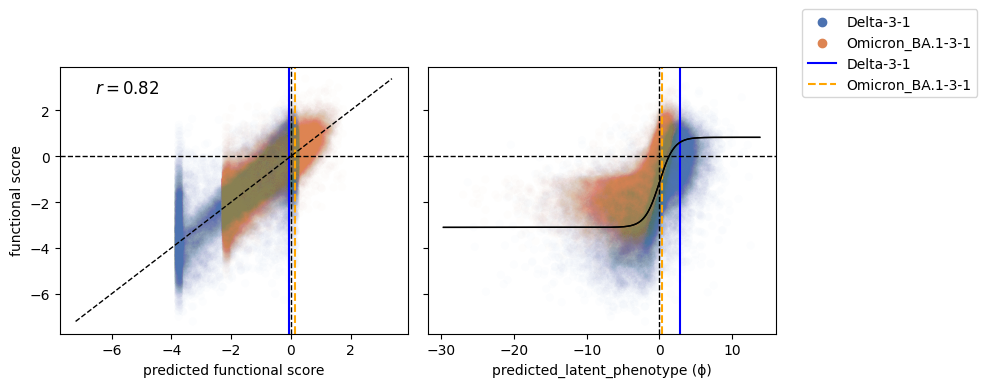

In [28]:
multidms.plot.plot_pred_scatter(results, hue=True)

In [26]:
# plot_param_hist(results)

In [27]:
# plot_param_heatmap(results)